    "all_wheels_on_track": Boolean,        # flag to indicate if the agent is on the track
    "x": float,                            # agent's x-coordinate in meters
    "y": float,                            # agent's y-coordinate in meters
    "closest_objects": [int, int],         # zero-based indices of the two closest objects to the agent's current position of (x, y).
    "closest_waypoints": [int, int],       # indices of the two nearest waypoints.
    "distance_from_center": float,         # distance in meters from the track center 
    "is_crashed": Boolean,                 # Boolean flag to indicate whether the agent has crashed.
    "is_left_of_center": Boolean,          # Flag to indicate if the agent is on the left side to the track center or not. 
    "is_offtrack": Boolean,                # Boolean flag to indicate whether the agent has gone off track.
    "is_reversed": Boolean,                # flag to indicate if the agent is driving clockwise (True) or counter clockwise (False).
    "heading": float,                      # agent's yaw in degrees
    "objects_distance": [float, ],         # list of the objects' distances in meters between 0 and track_length in relation to the starting line.
    "objects_heading": [float, ],          # list of the objects' headings in degrees between -180 and 180.
    "objects_left_of_center": [Boolean, ], # list of Boolean flags indicating whether elements' objects are left of the center (True) or not (False).
    "objects_location": [(float, float),], # list of object locations [(x,y), ...].
    "objects_speed": [float, ],            # list of the objects' speeds in meters per second.
    "progress": float,                     # percentage of track completed
    "speed": float,                        # agent's speed in meters per second (m/s)
    "steering_angle": float,               # agent's steering angle in degrees
    "steps": int,                          # number steps completed
    "track_length": float,                 # track length in meters.
    "track_width": float,                  # width of the track
    "waypoints": [(float, float), ]        # list of (x,y) as milestones along the track center

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# 2022_may_open_ccw - Ross Raceway Counter-Clockwise

In [2]:
import numpy as np


class Ref:
    history = {}


def compute_turn_radius(xy_vals: np.ndarray) -> float:
    '''
    Calculate the radius of the circle that best fits
    the list of points.

    https://www.geeksforgeeks.org/equation-of-circle-when-three-points-on-the-circle-are-given/

    Instead of using just 3 points, use the matrix solver to do
    a least squares fit of all the given points.

    Input shape::

        [[x1 y1],
        [x2 y2],
        [x3 y3],
        [.....]]

    '''
    if len(xy_vals) < 3:
        raise ValueError(f'Need at least 3 rows, got: {len(xy_vals)} rows')

    # eq of circle
    # (x - a)^2 + (y - b)^2 = r^2
    # a^2 + b^2 - r^2 = 2ax + 2by - x^2 - y^2

    # combining multiple rows
    # 2(x2 - x1)a + 2(y2 - y1)b = x2^2 - x1^2 + y2^2 - y1^2

    # represent as matrix C * d = h
    # where C is a matrix, h is a vector, and d = [a, b]
    x = xy_vals
    c = 2 * (x[1:] - x[:-1])
    tmp = x[:, 0] ** 2 + x[:, 1] ** 2
    h = tmp[1:] - tmp[:-1]

    # solution contains: d, residuals, rank, singular values
    solution = np.linalg.lstsq(c, h, rcond=1.5e-2)
    # print(f'Solution: {solution}')

    rank = solution[2]
    radius = 1e25  # default
    if rank >= 2:
        d = solution[0]
        # print(f'Center at: {d}')

        # compute radius as average of distance from centre
        # distance = sqrt((x - a)^2 + (y - b)^2)
        # d = [a, b]
        dists = ((x - d) ** 2).sum(axis=1) ** 0.5
        # print(f'Distances: {dists}')
        radius = dists.mean()
    # print(f'Radius: {radius}')
    return radius


def reward_function(params):
    '''
    Reward for staying close to centre line. Centreline reward
    to have an s-shaped curve based on logistic function.

    Reward for making more progress, for example by cutting corners.
    For this, the term effective speed has been devised which is computed
    based on the progress percentage and the track length. The effective
    speed is the speed that it would have been expected to travel at to have
    progressed that far around the track. This is compared to the actual
    average of all the speeds over the last 10 steps.

    The progress reward is then computed as the effective speed divided
    by the actual average speed, but don't reward if any wheels go
    off-track at any time during the previous 10 steps.

    Reward for achieving a target speed where the target speed is computed
    from the turn radius of the last 5 steps. If it took a very tight curve
    target speed will be lower so agent will have to go slower to get
    maximum reward.

    The centre, progress and speed are multiplied together.

    '''

    const_e = 2.718281828

    # Read input parameters
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    progress = params['progress']  # percentage
    nsteps = int(params['steps'])  # 1/10 second
    track_length = params['track_length']  # metres
    all_wheels_on_track = params['all_wheels_on_track']
    speed = params['speed']  # metres per second
    xpos = params['x']
    ypos = params['y']

    # Setup history
    history = Ref.history
    if nsteps <= 1:
        history.clear()
    history[nsteps] = {
        'progress': progress,
        'all_wheels_on_track': all_wheels_on_track,
        'speed': speed,
        'xpos': xpos,
        'ypos': ypos
    }

    # Overall scaling
    scaling_wt = 2.0

    # Raise progress to this exponent
    progress_power = 1.2

    # Raise speed to this exponent
    speed_power = 1.2

    # Higher speed or tighter radius gives higher force.
    # Compute a speed it should take the turn at to generate
    # the target force and reward for going at that speed.
    target_turn_force = 2.0
    # In the absence of turn force information
    # set a target speed
    default_speed = 1.5

    # Timestep assumed for progress computations
    steps_per_sec = 6

    # Logistic function parameters
    # https://en.wikipedia.org/wiki/Logistic_function
    # for following center
    k = 8  # steepness
    zone_width = 0.7  # normalized to track_width so 1.0 is at edge of track

    # logistic function for centerline
    x0 = zone_width * track_width / 2
    centreline_reward = 1 - 1 / (
        1 + const_e ** (k * (x0 - distance_from_center)))

    # progress reward is effective speed / actual average speed
    # where effective speed is computed by converting the
    # progress into a metres per second value based on the track length
    # initialize a default progress reward of 1.0
    progress_reward = 1.0  # default
    steps_in_history = [i for i in range(nsteps - 10, nsteps)
                        if i in history]
    if any(not history[i]['all_wheels_on_track'] for i in steps_in_history):
        # went off the track
        progress_reward = 0.001
    else:
        if len(steps_in_history) > 0:
            avg_speed = sum(history[i]['speed'] for i in steps_in_history) \
                    / len(steps_in_history)
            i = steps_in_history[0]
            effective_speed = (
                progress - history[i]['progress']
            ) * track_length / 100 * steps_per_sec / (nsteps - i)
            progress_reward = effective_speed / avg_speed
    # never negative
    progress_reward = max(0.001, progress_reward)

    # compute the turn radius from the previous 5 points
    # then target speed based on formula for centripetal force:
    # https://en.wikipedia.org/wiki/Centripetal_force
    # a = v^2 / r
    target_speed = default_speed
    avg_speed = speed  # default
    is_too_tight = False
    if len(steps_in_history) >= 5:
        xy_vals = np.array([
            [history[i]['xpos'], history[i]['ypos']]
            for i in steps_in_history
        ])
        turn_radius = compute_turn_radius(xy_vals)
        target_speed = (target_turn_force * turn_radius) ** 0.5
        avg_speed = sum(history[i]['speed'] for i in steps_in_history) \
            / len(steps_in_history)
        if target_speed < 0.7:
            is_too_tight = True
    speed_reward = 0.001  # default
    if not is_too_tight:
        target_speed = min(target_speed, 4.0)
        # Logistic function parameters
        # https://en.wikipedia.org/wiki/Logistic_function
        # for speed reward
        k2 = 15  # steepness
        x0_2 = 0.45  # width
        abs_speed_diff = abs(target_speed - avg_speed)
        speed_reward = 1 - 1 / (
            1 + const_e ** (k2 * (x0_2 - abs_speed_diff)))

    # Non-linear so more progress is rewarded
    return scaling_wt * centreline_reward \
        * progress_reward ** progress_power \
        * speed_reward ** speed_power


In [3]:
def plot_param(xmin, xmax, const_params, param_to_plot, reward_func):
    '''
    Plot output of the reward function by varying a single input parameter.
    
    xmin, xmax: range of input
    const_params: dict of values defining params to keep constant
    param_to_plot: name of parameter to plot
    reward_func: reward function matching standard deepracer signature
    '''
    x = list(np.linspace(xmin, xmax, num=40, dtype='O'))
    y = [
        reward_function({
            **const_params,
            param_to_plot: x_val
        })
        for x_val in x
    ]
    plt.figure()
    plt.plot(x, y, 'o')
    plt.grid()
    plt.show()

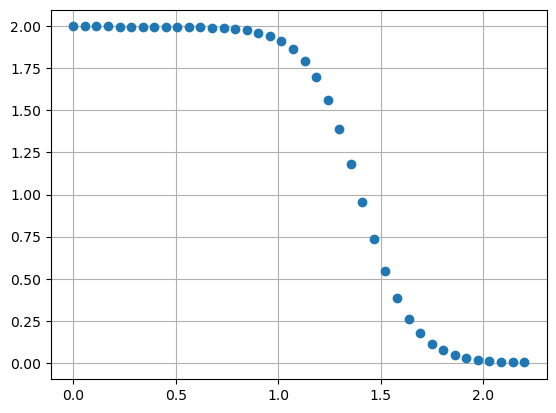

In [4]:
plot_param(
    0,
    2.2,
    const_params={'track_width': 4.0, 'progress': 50.0, 'steps': 250,
                  'track_length': 50, 'all_wheels_on_track': True,
                  'speed': 1.5, 'x': 2.0, 'y': 3.0},
    param_to_plot='distance_from_center',
    reward_func=reward_function
)

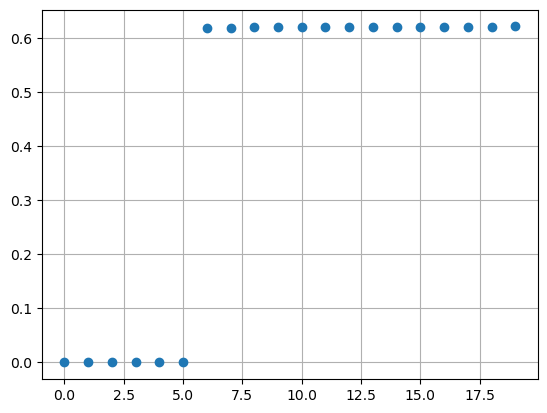

In [5]:
const_params={'track_width': 4.0, 'distance_from_center': 0.1,
              'track_length': 50, 'all_wheels_on_track': True,
              'speed': 4.0, 'x': 2.0, 'y': 3.0}
steps = list(range(20))
y = [
    reward_function({
        **const_params,
        'progress': s**1.002 * 1.5/6 * 100/50,
        'steps': s,
    })
    for s in steps
]
plt.figure()
plt.plot(steps, y, 'o')
plt.grid()
plt.show()

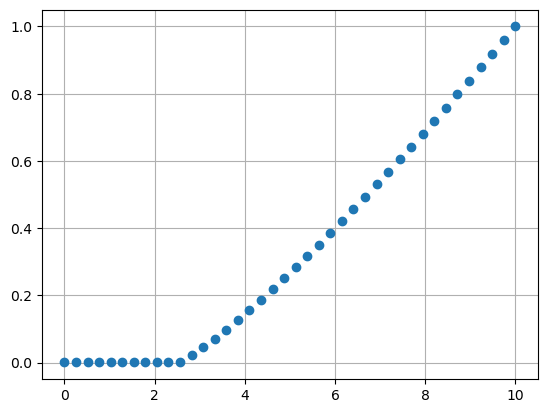

In [6]:
plot_param(
    0,
    10,
    const_params={'track_width': 4.0, 'distance_from_center': 0.1,
                  'track_length': 50, 'all_wheels_on_track': True,
                  'speed': 4.0, 'steps': 15, 'x': 2.0, 'y': 3.0},
    param_to_plot='progress',
    reward_func=reward_function
)

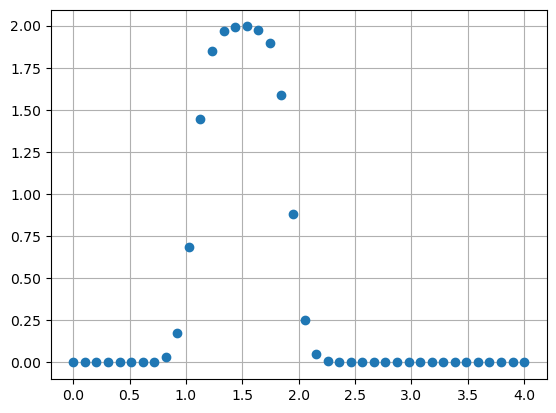

In [7]:
plot_param(
    0,
    4,
    const_params={'track_width': 4.0, 'distance_from_center': 0.1,
                  'track_length': 50, 'all_wheels_on_track': True,
                  'progress': 10, 'steps': 55, 'x': 2.0, 'y': 3.0},
    param_to_plot='speed',
    reward_func=reward_function
)

In [14]:
# make it go off track
for i in range(10, 12):
    reward_function({
        'track_width': 4.0, 'distance_from_center': 0.1,
        'track_length': 50, 'all_wheels_on_track': False,
        'speed': 2.0, 'steps': i, 'progress': 3, 'x': 2.0, 'y': 3.0
    })

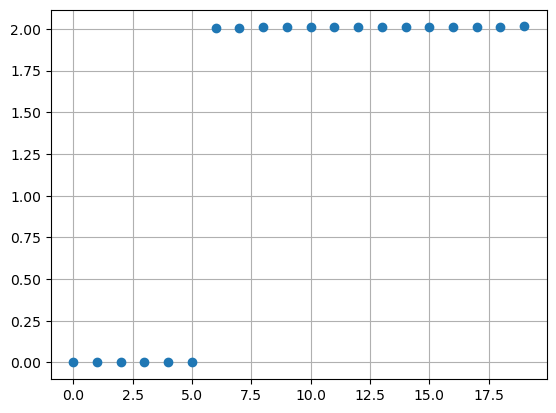

In [8]:
# check with optimal radius
const_params={'track_width': 4.0, 'distance_from_center': 0.1,
              'track_length': 50, 'all_wheels_on_track': True,
              'speed': 3.2}
steps = list(range(20))
y = [
    reward_function({
        **const_params,
        'progress': s**1.002 * 3.2/6 * 100/50,
        'steps': s,
        'x': 5.12 * np.cos(s * np.pi / 180.0),
        'y': 5.12 * np.sin(s * np.pi / 180.0)
    })
    for s in steps
]
plt.figure()
plt.plot(steps, y, 'o')
plt.grid()
plt.show()

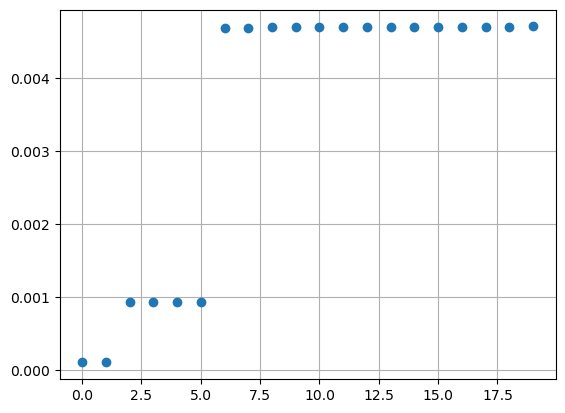

In [16]:
# check if radius is too tight
const_params={'track_width': 4.0, 'distance_from_center': 0.1,
              'track_length': 50, 'all_wheels_on_track': True,
              'speed': 0.5}
steps = list(range(20))
y = [
    reward_function({
        **const_params,
        'progress': s**1.002 * 3.2/6 * 100/50,
        'steps': s,
        'x': 0.243 * np.cos(s * np.pi / 180.0),
        'y': 0.243 * np.sin(s * np.pi / 180.0)
    })
    for s in steps
]
plt.figure()
plt.plot(steps, y, 'o')
plt.grid()
plt.show()